### A simple Renting vs Buying calculator

I'm sure there are a bunch of variables that I didn't include, say tax deductions. For a rule of thumb estimate, tho, this should be enough.

#### Usage
* Change the numbers in each of the blocks commented with `### USER CONFIG` with what ever fits your situation
* Run all
* Voilà

#### A grain of salt
* Some co-worker: Did you test your code?
* Me: What's test?
* Some co-worker: (**facepalm intensifies**)

Anyway, all jokes aside, I know most of the rate params are fine. But I'm sure there are many cases that are not handled.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
def convert_annual_2_monthly(rate: float) -> float:
    return (
        np.power(
            np.e,
            np.log(
                1.0 + rate / 100.0 / 12.0
            )
        ) - 1
    ) * 100

In [3]:
### USER CONFIG

# More static stuff
agentCommisionRate = 8.0  # overestimated to cover other cost

overheadGrowthMonthly = 0.5

propertyTaxRateAnnually = 1.0 # overestimated from 0.953

In [4]:
### USER CONFIG
### Investment rate, Appreciation Rate, etc.

rentGrowthRatePerYear = 5.0
rentGrowthRatePerMonth = convert_annual_2_monthly(rentGrowthRatePerYear)
print("Converted rent growth rate to monthly: {:.3f}".format(rentGrowthRatePerMonth))

projectedInvestmentGrowthPerYear = 7.0
projectedInvestmentGrowthPerMonth = convert_annual_2_monthly(projectedInvestmentGrowthPerYear)
print("Converted investment rate to monthly: {:.3f}".format(projectedInvestmentGrowthPerMonth))

houseApperciationRatePerYear = 5.0
houseApperciationRatePerMonth = convert_annual_2_monthly(houseApperciationRatePerYear)
print("Converted houseApperciation rate to monthly: {:.3f}".format(projectedInvestmentGrowthPerMonth))

savingIncreaseRatePerYear = 5.0
savingIncreateRatePerMonth = convert_annual_2_monthly(savingIncreaseRatePerYear)
print("Converted saving increase rate to monthly: {:.3f}".format(savingIncreateRatePerMonth))

Converted rent growth rate to monthly: 0.417
Converted investment rate to monthly: 0.583
Converted houseApperciation rate to monthly: 0.583
Converted saving increase rate to monthly: 0.417


In [5]:
### USER CONFIG
### House, loan, and finanical details

# How much cash you have on your hand
cashOnHand = 42000

# exclude utilities
rent = 2200 
# Node: This doesn't really change the outcome, so....
savingPerMonth = 2000

# Purchase price of the house
houseCost = 440000
# The tax value of the home, for caculating how many beans you own Uncle Sam.
taxValue = 	440000

# Loan origination fees
closingCost = 5000
# the down payment percentage
downPercentage = 5.0
# DONT TOUCH THIS
downPayment = houseCost * downPercentage / 100.0

# Your monthly interest rate, NOT YOU APR
interestRate = 3.375
# The loan term length
paymentPeriodMonth = 360

# HOA + Insurance + internet + water + gas/electricity + PMI + random cost
overhead = 480 + 60 + 70 + 100 + 100 + 160 + 200 
print("Monthly overhead is {}".format(overhead))

Monthly overhead is 1170


In [6]:
upfrontCost = downPayment + closingCost
print("Total upfront is: {}".format(upfrontCost))

Total upfront is: 27000.0


In [7]:
principal = houseCost - downPayment
effectiveMonthRate = interestRate / 12 / 100

paymentLoan = (
    principal *
    effectiveMonthRate *
    np.power(1 + effectiveMonthRate, paymentPeriodMonth) /
    (np.power(1 + effectiveMonthRate, paymentPeriodMonth) - 1)
)

print("Monthly payment is: {:.0f}".format(paymentLoan))

Monthly payment is: 1848


In [8]:
df = pd.DataFrame()
df["month"] = np.arange(paymentPeriodMonth)

In [9]:
def caculate_savings_renting(month, saving_rate):
    if month == 0:
        return cashOnHand
    else:
        return (
            caculate_savings_renting(month - 1, saving_rate) * (1 + projectedInvestmentGrowthPerMonth / 100) + 
            saving_rate * np.power(1 + savingIncreateRatePerMonth / 100, month)
        )


In [10]:
df["networth_renting"] = df["month"].apply(lambda x: caculate_savings_renting(x, savingPerMonth))

In [11]:
df["property_tax"] = df["month"].apply(lambda x: taxValue * propertyTaxRateAnnually / 100 / 12 * np.power(1 + houseApperciationRatePerMonth / 12 / 100, x))

In [12]:
df["hoa"] = df["month"].apply(lambda x: overhead * np.power(1 + overheadGrowthMonthly / 12 / 100, x))

In [13]:
df["payment"] = df["month"] * 0 + paymentLoan + df["property_tax"] + df["hoa"]

In [14]:
interval = 24

print("Expected monthly total upkeep (loan + tax + all overhead): ")
for x in np.arange(0, paymentPeriodMonth, interval):
    print("@ ({})-th month is: {:.0f}".format(x, df["payment"][x]))

Expected monthly total upkeep (loan + tax + all overhead): 
@ (0)-th month is: 3385
@ (24)-th month is: 3399
@ (48)-th month is: 3414
@ (72)-th month is: 3430
@ (96)-th month is: 3445
@ (120)-th month is: 3460
@ (144)-th month is: 3476
@ (168)-th month is: 3491
@ (192)-th month is: 3507
@ (216)-th month is: 3523
@ (240)-th month is: 3540
@ (264)-th month is: 3556
@ (288)-th month is: 3572
@ (312)-th month is: 3589
@ (336)-th month is: 3606


In [15]:
df["payment_subtotal"] = df["month"].apply(lambda x: df["payment"][:x].sum())

In [16]:
df["saving_before_payment"] = df["month"].apply(lambda x: (rent + savingPerMonth) * np.power(1 + savingIncreateRatePerMonth / 100, x))

In [17]:
df["saving_after_payment"] = df["saving_before_payment"] - df["payment"]

In [18]:
def calculate_savings_buying(df, month):
    if month == 0:
        return cashOnHand - upfrontCost
    return calculate_savings_buying(df, month - 1) * (1 + projectedInvestmentGrowthPerMonth / 100) +  df["saving_after_payment"][month]

In [19]:
df["networth_from_savings"] = df["month"].apply(lambda x: calculate_savings_buying(df, x))

In [20]:
df["principal_left"] = df["month"].apply(lambda x: principal * np.power(1 + effectiveMonthRate, x) - paymentLoan * ((np.power(1 + effectiveMonthRate, x) - 1) / effectiveMonthRate))

In [21]:
df["house_worth"] = df["month"].apply(lambda x: houseCost * np.power(1 + houseApperciationRatePerMonth / 100, x))

In [22]:
df["networth_from_house"] = df["house_worth"] * (1 - agentCommisionRate / 100) - df["principal_left"]

In [23]:
df["networth_buying"] = df["networth_from_house"]  + df["networth_from_savings"]

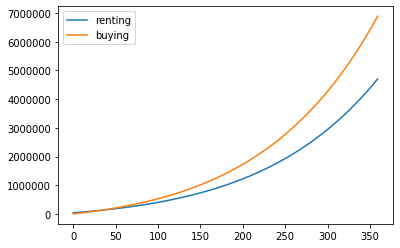

In [24]:
p = plt.plot(df["month"], df["networth_renting"], df["networth_buying"])

plt.legend(p, ("renting", "buying"))

In [25]:
monthTillRentingIsBetter = ((df["networth_renting"] - df["networth_buying"]) < 0).ne(True).idxmin()

# Renting is always better case
assert ((df["networth_renting"] - df["networth_buying"]) < 0).ne(True).sum() != paymentPeriodMonth

print("Renting would result in more net worth after {} month".format(monthTillRentingIsBetter))

Renting would result in more net worth after 34 month


In [26]:
pd.set_option('display.max_rows', None)

In [27]:
df["rent_minus_buying"] = df["networth_renting"] - df["networth_buying"]

In [28]:
(df["rent_minus_buying"] < 0).sum()

326

In [29]:
df

,month,networth_renting,property_tax,hoa,payment,payment_subtotal,saving_before_payment,saving_after_payment,networth_from_savings,principal_left,house_worth,networth_from_house,networth_buying,rent_minus_buying
0,0,4.200000e+04,366.666667,1170.000000,3384.628826,0.000000e+00,4200.000000,815.371174,1.500000e+04,418000.000000,4.400000e+05,-1.320000e+04,1.800000e+03,4.020000e+04
1,1,4.425333e+04,366.793981,1170.487500,3385.243640,3.384629e+03,4217.500000,832.256360,1.591976e+04,417327.662841,4.418333e+05,-1.084100e+04,5.078760e+03,3.917457e+04
2,2,4.652818e+04,366.921341,1170.975203,3385.858703,6.769872e+03,4235.072917,849.214214,1.686184e+04,416653.434734,4.436743e+05,-8.473074e+03,8.388762e+03,3.813942e+04
3,3,4.882470e+04,367.048744,1171.463109,3386.474012,1.015573e+04,4252.719054,866.245042,1.782644e+04,415977.310360,4.455229e+05,-6.096198e+03,1.173024e+04,3.709445e+04
4,4,5.114305e+04,367.176191,1171.951219,3387.089569,1.354221e+04,4270.438717,883.349147,1.881378e+04,415299.284387,4.473793e+05,-3.710334e+03,1.510344e+04,3.603961e+04
5,5,5.348340e+04,367.303683,1172.439532,3387.705374,1.692929e+04,4288.232211,900.526837,1.982405e+04,414619.351465,4.492434e+05,-1.315447e+03,1.850861e+04,3.497480e+04
6,6,5.584591e+04,367.431219,1172.928049,3388.321426,2.031700e+04,4306.099845,917.778419,2.085747e+04,413937.506232,4.511152e+05,1.088498e+03,2.194597e+04,3.389994e+04
7,7,5.823075e+04,367.558799,1173.416769,3388.937727,2.370532e+04,4324.041928,935.104201,2.191424e+04,413253.743310,4.529949e+05,3.501536e+03,2.541578e+04,3.281497e+04
8,8,6.063807e+04,367.686424,1173.905692,3389.554275,2.709426e+04,4342.058769,952.504494,2.299458e+04,412568.057304,4.548823e+05,5.923702e+03,2.891828e+04,3.171979e+04
9,9,6.306806e+04,367.814093,1174.394820,3390.171071,3.048381e+04,4360.150681,969.979610,2.409870e+04,411880.442806,4.567777e+05,8.355032e+03,3.245373e+04,3.061433e+04
